# SNIR+GAT
- 任务1：跨个体估计任务特定的脑区影响因子 $\rho_j$
- 任务2：使用 $\rho_j$ 调节GAT架构（暂时从偏置入手），做多任务预测（集中`SRS量表`）

> 数据基于`hx`

## 任务1-跨个体估计任务特定的脑区影响因子 $\rho_j$

1. 依赖包和路径

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

DATA_DIR = 'hx/'  # 存放 FC 矩阵的路径
INFO_PATH = 'hxinfo.csv'
NODE_INFO_PATH = 'x_dosenbach.csv'

# 回归目标（可以替换为 SRS_awareness 等）
TARGET_COL = 'SRS_mannerisms'

# 正则化参数搜索范围
ALPHA_GRID = np.logspace(-4, 1, 30)

2. 表型信息读取+ID提取

In [2]:
info_df = pd.read_csv(INFO_PATH)
print(f"共读取被试数量: {len(info_df)}")

# 选定目标列作为 y
y_all = info_df[[TARGET_COL, 'ID']].dropna()
y_all = y_all.reset_index(drop=True)
print(f"包含目标 {TARGET_COL} 的有效被试数: {len(y_all)}")

# 将 ID 匹配为 z<ID>.txt 文件路径
y_all['A_path'] = y_all['ID'].apply(lambda x: os.path.join(DATA_DIR, f'z{x}.txt'))

共读取被试数量: 218
包含目标 SRS_mannerisms 的有效被试数: 218


3. 节点特征Y（暂时取静态结构特征）

In [3]:
node_df = pd.read_csv(NODE_INFO_PATH)
Y_xyz = node_df[['x(mm)', 'y(mm)', 'z(mm)']].values.astype(float)  # shape: (160, 3)

# 标准化静态特征
scaler_y = StandardScaler()
Y_xyz_std = scaler_y.fit_transform(Y_xyz)

4. Z构造（传播响应）
    - 每个被试 Z = A * enriched_Y
    - enriched_Y = \[xyz_std + subnet_onehot\]（拼接中心坐标与子网络one-hot）

In [4]:
# 提取子网 one-hot 编码
subnet_onehot = pd.get_dummies(node_df['Subnetwork'])  # shape: (160, 6)
Y_enriched = np.concatenate([Y_xyz_std, subnet_onehot.values], axis=1)  # shape: (160, 9)

Z_list = []
valid_ids = []
for idx, row in y_all.iterrows():
    try:
        A = np.loadtxt(row['A_path'])
        if A.shape != (160, 160):
            print(f"跳过 {row['ID']}，尺寸不符: {A.shape}")
            continue
        Z = A @ Y_enriched       # shape: (160, 9)
        Z_flat = Z.flatten()     # shape: (160 * 9 = 1440,)
        Z_list.append(Z_flat)
        valid_ids.append(row['ID'])
    except Exception as e:
        print(f"跳过 {row['ID']}，读取失败: {e}")

Z_all = np.stack(Z_list, axis=0)  # shape: (M, 1440)
print(f"成功处理样本数量: {len(Z_all)}")

跳过 ASD1013，读取失败: hx/zASD1013.txt not found.
跳过 ASD1018 ，读取失败: hx/zASD1018 .txt not found.
跳过 ASD1051，读取失败: hx/zASD1051.txt not found.
跳过 ASD1075，读取失败: hx/zASD1075.txt not found.
跳过 ASD1112，读取失败: hx/zASD1112.txt not found.
跳过 ASD1115，读取失败: hx/zASD1115.txt not found.
跳过 ASD1125，读取失败: hx/zASD1125.txt not found.
跳过 ASD1132，读取失败: hx/zASD1132.txt not found.
跳过 ASD1133，读取失败: hx/zASD1133.txt not found.
跳过 ASD1145，读取失败: hx/zASD1145.txt not found.
跳过 ASD1147，读取失败: hx/zASD1147.txt not found.
跳过 ASD1149，读取失败: hx/zASD1149.txt not found.
跳过 ASD1150，读取失败: hx/zASD1150.txt not found.
跳过 TD139，读取失败: hx/zTD139.txt not found.
跳过 TD208，读取失败: hx/zTD208.txt not found.
跳过 TD226，读取失败: hx/zTD226.txt not found.
跳过 TD249，读取失败: hx/zTD249.txt not found.
成功处理样本数量: 201


5. Lasso估计$\rho_j$

In [5]:
# 提取匹配的 y
y_final = y_all[y_all['ID'].isin(valid_ids)][TARGET_COL].values

# 标准化
scaler_z = StandardScaler()
Z_scaled = scaler_z.fit_transform(Z_all)
y_scaled = (y_final - y_final.mean()) / y_final.std()

# LassoCV 自动调参
lasso = LassoCV(alphas=ALPHA_GRID, cv=5, max_iter=10000)
lasso.fit(Z_scaled, y_scaled)
rho_hat = lasso.coef_  # shape: (160,)
print("Lasso 回归完成")

Lasso 回归完成


6. output & visualization

Top 10 影响脑区：


,Labels,Regions,Hemishpere,rho
49,50,post parietal,L,0.125433
75,76,post insula,L,0.064527
2,3,aPFC,L,0.058287
0,1,vmPFC,R,0.049091
21,22,precuneus,R,0.048712
63,64,mFC,NaN,0.045387
156,157,med cerebellum,R,0.044809
92,93,SMA,NaN,0.036287
130,131,occipital,L,0.033507
119,120,sup parietal,R,0.021764


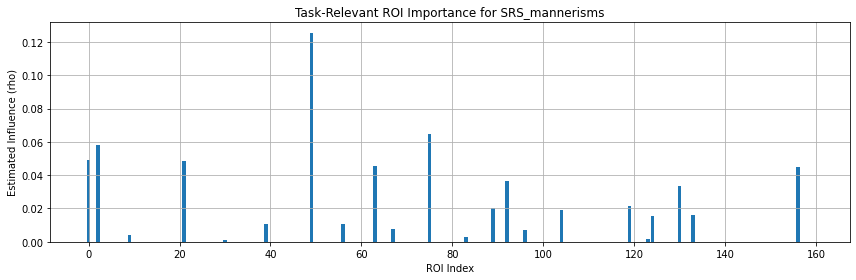

In [6]:
np.save('rho_estimate.npy', rho_hat)

# 排序并显示 top 10 ROI

rho_matrix = rho_hat.reshape(160, 9)  # 恢复成原 shape
rho_roi = np.linalg.norm(rho_matrix, axis=1)  # 每个 ROI 的重要性
node_df['rho'] = rho_roi

node_df_sorted = node_df.sort_values('rho', key=abs, ascending=False)
print("Top 10 影响脑区：")
display(node_df_sorted[['Labels', 'Regions', 'Hemishpere', 'rho']].head(10))

# 可视化
plt.figure(figsize=(12, 4))
plt.bar(np.arange(160), rho_roi)
plt.xlabel('ROI Index')
plt.ylabel('Estimated Influence (rho)')
plt.title(f'Task-Relevant ROI Importance for {TARGET_COL}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
import os

root_dir = '/root/autodl-tmp/snir+gat'
def print_tree(root_dir, prefix=""):
    entries = sorted(os.listdir(root_dir))
    for i, entry in enumerate(entries):
        path = os.path.join(root_dir, entry)
        connector = "├── " if i < len(entries) - 1 else "└── "
        print(prefix + connector + entry)
        if os.path.isdir(path):
            extension = "│   " if i < len(entries) - 1 else "    "
            print_tree(path, prefix + extension)
print_tree(root_dir, prefix="")

├── .ipynb_checkpoints
│   ├── config-checkpoint.py
│   └── run_task2-checkpoint.py
├── config.py
├── data
├── models
│   ├── .ipynb_checkpoints
│   │   ├── rho_adjusted_gat-checkpoint.py
│   │   └── vanilla_gat-checkpoint.py
│   ├── rho_adjusted_gat.py
│   └── vanilla_gat.py
├── results
├── run_task2.py
├── train
│   ├── .ipynb_checkpoints
│   │   ├── evaluate-checkpoint.py
│   │   └── train_gat-checkpoint.py
│   ├── evaluate.py
│   └── train_gat.py
└── utils
    ├── .ipynb_checkpoints
    │   ├── data_loader-checkpoint.py
    │   ├── feature_select-checkpoint.py
    │   └── graph_utils-checkpoint.py
    ├── data_loader.py
    ├── feature_select.py
    └── graph_utils.py


## 任务2-使用 $\rho_j$ 调节GAT架构（暂时从偏置入手），做多任务预测（集中`SRS_mannerisms`）

> 见`snir+gat`